# ZTM Learn Pytorch

[https://www.learnpytorch.io/07_pytorch_experiment_tracking/](https://www.learnpytorch.io/07_pytorch_experiment_tracking/)

**We're going to answer the question: how do I track my machine learning experiments?**

If you're only running a handful of models (like we've done so far), it might be okay just to track their results in print outs and a few dictionaries.

However, as the number of experiments you run starts to increase, this naive way of tracking could get out of hand.

### Different ways to track machine learning experiments

- python dicts/csv/prints
- tensorboard
- weightsandbiases
- MLflow

## What we're going to cover

We're going to be running several different modelling experiments with various levels of data, model size and training time to try and improve on FoodVision Mini.

And due to its tight integration with PyTorch and widespread use, this notebook focuses on using TensorBoard to track our experiments.

However, the principles we're going to cover are similar across all of the other tools for experiment tracking.

---

## OVERVIEW

Basically we repeat all the first steps as before, nothing new, so I skip some notes (import his module for loading same dataset etc)

In [1]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

[INFO] torch/torchvision versions not as required, installing nightly versions.


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 9.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 12.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 11.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 4.7 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 731.7/731.7 MB 146.2 MB/s eta 0:00:0100:01  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.16.2+cpu
    Uninstalling torchvision-0.16.2+cpu:
      Successfully uninstalled torchvision-0.16.2+cpu
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.1.2+cpu
    Uninstalling

In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4056, done.
remote: Total 4056 (delta 0), reused 0 (delta 0), pack-reused 4056
Receiving objects: 100% (4056/4056), 646.90 MiB | 47.73 MiB/s, done.
Resolving deltas: 100% (2372/2372), done.
Updating files: 100% (248/248), done.


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Create a helper function to set seeds

Since we've been setting random seeds a whole bunch throughout previous sections, how about we functionize it?

Let's create a function to "set the seeds" called set_seeds().

In [4]:
# Set seeds
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

## 1. Get Data

We're going to continue trying to improve upon the results we've been getting on FoodVision Mini.

In the previous section, 06. PyTorch Transfer Learning, we saw how powerful using a pretrained model and transfer learning could be when classifying images of pizza, steak and sushi.

So how about we run some experiments and try to further improve our results?

To do so, we'll use similar code to the previous section to download the pizza_steak_sushi.zip (if the data doesn't already exist) except this time its been functionised.

This will allow us to use it again later.

In [5]:
import os
import zipfile

from pathlib import Path

import requests

def download_data(source: str, 
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.
    
    Returns:
        pathlib.Path to downloaded data.
    
    Example usage:
        download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it... 
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)
        
        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...") 
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path

image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Did not find data/pizza_steak_sushi directory, creating one...
[INFO] Downloading pizza_steak_sushi.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip...
[INFO] Unzipping pizza_steak_sushi.zip data...


PosixPath('data/pizza_steak_sushi')

## 2. Create Datasets and DataLoaders


2. Create Datasets and DataLoaders
Now we've got some data, let's turn it into PyTorch DataLoaders.

We can do so using the create_dataloaders() function we created in 05. PyTorch Going Modular part 2.

And since we'll be using transfer learning and specifically pretrained models from torchvision.models, we'll create a transform to prepare our images correctly.

To transform our images in tensors, we can use:

Manually created transforms using torchvision.transforms.
Automatically created transforms using torchvision.models.MODEL_NAME.MODEL_WEIGHTS.DEFAULT.transforms().
Where MODEL_NAME is a specific torchvision.models architecture, MODEL_WEIGHTS is a specific set of pretrained weights and DEFAULT means the "best available weights".
We saw an example of each of these in 06. PyTorch Transfer Learning section 2.

Let's see first an example of manually creating a torchvision.transforms pipeline (creating a transforms pipeline this way gives the most customization but can potentially result in performance degradation if the transforms don't match the pretrained model).

The main manual transformation we need to be sure of is that all of our images are normalized in ImageNet format (this is because pretrained torchvision.models are all pretrained on ImageNet).

We can do this with:

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

### 2.1 Create DataLoaders using manually created transforms

In [6]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"Manually created transforms: {manual_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7e5fd9d3cc40>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Create DataLoaders using automatically created transforms

We can do this by first instantiating a set of pretrained weights (for example weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT) we'd like to use and calling the transforms() method on it.

In [7]:
# Setup dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"Automatically created transforms: {automatic_transforms}")

# Create data loaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=automatic_transforms, # use automatic created transforms
    batch_size=32
)

train_dataloader, test_dataloader, class_names

Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7e5fca9516c0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model, freezing the base layers and changing the classifier head

In [8]:
# Note: This is how a pretrained model would be created in torchvision > 0.13, it will be deprecated in future versions.
# model = torchvision.models.efficientnet_b0(pretrained=True).to(device) # OLD 

# Download the pretrained weights for EfficientNet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # NEW in torchvision 0.13, "DEFAULT" means "best weights available"

# Setup the model with the pretrained weights and send it to the target device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the output of the model
# model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 106MB/s] 


In [9]:
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
# Freeze all base layers by setting requires_grad attribute to False
for param in model.features.parameters():
    param.requires_grad = False
    
# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds() 

# Update the classifier head to suit our problem
model.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, 
              out_features=len(class_names),
              bias=True).to(device))

In [11]:
## --- good practice after freezing base layers and changing classifier head to look at summary ---

from torchinfo import summary

# # Get a summary of the model (uncomment for full output)
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4. Train model and track results

In [12]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# NEW STUFF

## Adjust train() function to track results with SummaryWriter()

Beautiful!

All of the pieces of our training code are starting to come together.

Let's now add the final piece to track our experiments.

Previously, we've tracked our modelling experiments using multiple Python dictionaries (one for each model).

But you can imagine this could get out of hand if we were running anything more than a few experiments.

Not to worry, there's a better option!

We can use PyTorch's torch.utils.tensorboard.SummaryWriter() class to save various parts of our model's training progress to file.

By default, the SummaryWriter() class saves various information about our model to a file set by the log_dir parameter.

The default location for log_dir is under runs/CURRENT_DATETIME_HOSTNAME, where the HOSTNAME is the name of your computer.

But of course, you can change where your experiments are tracked (the filename is as customisable as you'd like).

The outputs of the SummaryWriter() are saved in TensorBoard format.

TensorBoard is a part of the TensorFlow deep learning library and is an excellent way to visualize different parts of your model.

To start tracking our modelling experiments, let's create a default SummaryWriter() instance.

In [13]:
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

2024-04-10 21:27:58.522061: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 21:27:58.522388: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 21:27:58.697662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Now to use the writer, we could write a new training loop or we could adjust the existing train() function we created in 05. PyTorch Going Modular section 4.

Let's take the latter option.

We'll get the train() function from engine.py and adjust it to use writer.

Specifically, we'll add the ability for our train() function to log our model's training and test loss and accuracy values.

We can do this with writer.add_scalars(main_tag, tag_scalar_dict), where:

main_tag (string) - the name for the scalars being tracked (e.g. "Accuracy")
tag_scalar_dict (dict) - a dictionary of the values being tracked (e.g. {"train_loss": 0.3454})
Note: The method is called add_scalars() because our loss and accuracy values are generally scalars (single values).

Once we've finished tracking values, we'll call writer.close() to tell the writer to stop looking for values to track.

To start modifying train() we'll also import train_step() and test_step() from engine.py.

Note: You can track information about your model almost anywhere in your code. But quite often experiments will be tracked while a model is training (inside a training/testing loop).

The torch.utils.tensorboard.SummaryWriter() class also has many different methods to track different things about your model/data, such as add_graph() which tracks the computation graph of your model. For more options, check the SummaryWriter() documentation.

In [14]:
from typing import Dict, List
from tqdm.auto import tqdm

from going_modular.going_modular.engine import train_step, test_step

# Import train() function from: 
# https://github.com/mrdbourke/pytorch-deep-learning/blob/main/going_modular/going_modular/engine.py
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      
    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_fn=loss_fn,
                                        device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # Add loss results to SummaryWriter
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)

        # Add accuracy results to SummaryWriter
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_acc": train_acc,
                                            "test_acc": test_acc}, 
                           global_step=epoch)
        
        # Track the PyTorch model architecture
        writer.add_graph(model=model, 
                         # Pass in an example input
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    
    # Close the writer
    writer.close()
    
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

Our train() function is now updated to use a SummaryWriter() instance to track our model's results.

How about we try it out for 5 epochs?

In [15]:
# Train model
# Note: Not using engine.train() since the original script isn't updated to use writer
set_seeds()
results = train(model=model,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=5,
                device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0966 | train_acc: 0.3867 | test_loss: 0.8843 | test_acc: 0.6828
Epoch: 2 | train_loss: 0.9204 | train_acc: 0.6445 | test_loss: 0.8134 | test_acc: 0.7746
Epoch: 3 | train_loss: 0.7602 | train_acc: 0.8750 | test_loss: 0.6562 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.6868 | train_acc: 0.7695 | test_loss: 0.6201 | test_acc: 0.8759
Epoch: 5 | train_loss: 0.6467 | train_acc: 0.7969 | test_loss: 0.6054 | test_acc: 0.8665


Running the cell above we get similar outputs we got in 06. PyTorch Transfer Learning section 4: Train model but the difference is behind the scenes our writer instance has created a runs/ directory storing our model's results.

For example, the save location might look like:

runs/Jun21_00-46-03_daniels_macbook_pro
Where the default format is runs/CURRENT_DATETIME_HOSTNAME.

We'll check these out in a second but just as a reminder, we were previously tracking our model's results in a dictionary.

In [16]:
# check results 
results

{'train_loss': [1.0965989083051682,
  0.9203867241740227,
  0.7602227181196213,
  0.686808105558157,
  0.6466987803578377],
 'train_acc': [0.38671875, 0.64453125, 0.875, 0.76953125, 0.796875],
 'test_loss': [0.8842612902323405,
  0.8134126663208008,
  0.6561942100524902,
  0.6200586358706156,
  0.6053729057312012],
 'test_acc': [0.6827651515151515,
  0.774621212121212,
  0.8863636363636364,
  0.8759469696969697,
  0.8664772727272728]}

## 5. View our model's results in TensorBoard

The SummaryWriter() class stores our model's results in a directory called runs/ in TensorBoard format by default.

TensorBoard is a visualization program created by the TensorFlow team to view and inspect information about models and data.

You know what that means?

It's time to follow the data visualizer's motto and visualize, visualize, visualize!

You can view TensorBoard in a number of ways:

VSCODE - Python Launch Tensorboard in Comand Palette

JupyterNotebook - Make sure TensorBoard is installed, load it with %load_ext tensorboard and then view your results with %tensorboard --logdir DIR_WITH_LOGS

In [17]:
# Example code to run in Jupyter or Google Colab Notebook (uncomment to try it out)
%load_ext tensorboard
%tensorboard --logdir runs

## 6. Create a helper function to build SummaryWriter() instances

The SummaryWriter() class logs various information to a directory specified by the log_dir parameter.

How about we make a helper function to create a custom directory per experiment?

In essence, each experiment gets its own logs directory.

For example, say we'd like to track things like:

Experiment date/timestamp - when did the experiment take place?
Experiment name - is there something we'd like to call the experiment?
Model name - what model was used?
Extra - should anything else be tracked?
You could track almost anything here and be as creative as you want but these should be enough to start.

Let's create a helper function called create_writer() that produces a SummaryWriter() instance tracking to a custom log_dir.

Ideally, we'd like the log_dir to be something like:

runs/YYYY-MM-DD/experiment_name/model_name/extra

Where YYYY-MM-DD is the date the experiment was run (you could add the time if you wanted to as well).

In [18]:
def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    from datetime import datetime
    import os

    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

In [19]:
# Create an example writer
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb0",
                               extra="5_epochs")

[INFO] Created SummaryWriter, saving to: runs/2024-04-10/data_10_percent/effnetb0/5_epochs...


## 6.1 Update the train() function to include a writer parameter

Our create_writer() function works fantastic.

How about we give our train() function the ability to take in a writer parameter so we actively update the SummaryWriter() instance we're using each time we call train().

For example, say we're running a series of experiments, calling train() multiple times for multiple different models, it would be good if each experiment used a different writer.

One writer per experiment = one logs directory per experiment.

To adjust the train() function we'll add a writer parameter to the function and then we'll add some code to see if there's a writer and if so, we'll track our information there.

In [20]:
from typing import Dict, List
from tqdm.auto import tqdm

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

## 7. Setting up a series of modelling experiments

It's to step things up a notch.

Previously we've been running various experiments and inspecting the results one by one.

But what if we could run multiple experiments and then inspect the results all together?

### 7.1 What kind of experiments should you run?

That's the million dollar question in machine learning.

Because there's really no limit to the experiments you can run.

data / learning rate / layers / hidden units / epochs etc etc

Your first batch of experiments should take no longer than a few seconds to a few minutes to run.

The quicker you can experiment, the faster you can work out what doesn't work, in turn, the faster you can work out what does work.

### 7.2 What experiments are we going to run?

Our goal is to improve the model powering FoodVision Mini without it getting too big.

In essence, our ideal model achieves a high level of test set accuracy (90%+) but doesn't take too long to train/perform inference (make predictions).

We've got plenty of options but how about we keep things simple?

Let's try a combination of:

A different amount of data (10% of Pizza, Steak, Sushi vs. 20%)
A different model (torchvision.models.efficientnet_b0 vs. torchvision.models.efficientnet_b2)
A different training time (5 epochs vs. 10 epochs)

---

### 7.3 Download different datasets

Before we start running our series of experiments, we need to make sure our datasets are ready.

We'll need two forms of a training set:

A training set with 10% of the data of Food101 pizza, steak, sushi images (we've already created this above but we'll do it again for completeness).
A training set with 20% of the data of Food101 pizza, steak, sushi images.
For consistency, all experiments will use the same testing dataset (the one from the 10% data split).

We'll start by downloading the various datasets we need using the download_data() function we created earlier.

Both datasets are available from the course GitHub:

In [21]:
# Download 10 percent and 20 percent training data (if necessary)
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                     destination="pizza_steak_sushi")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

[INFO] data/pizza_steak_sushi directory exists, skipping download.
[INFO] Did not find data/pizza_steak_sushi_20_percent directory, creating one...
[INFO] Downloading pizza_steak_sushi_20_percent.zip from https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip...
[INFO] Unzipping pizza_steak_sushi_20_percent.zip data...


In [22]:
# Setup training directory paths
train_dir_10_percent = data_10_percent_path / "train"
train_dir_20_percent = data_20_percent_path / "train"

# Setup testing directory paths (note: use the same test dataset for both to compare the results)
test_dir = data_10_percent_path / "test"

# Check the directories
print(f"Training directory 10%: {train_dir_10_percent}")
print(f"Training directory 20%: {train_dir_20_percent}")
print(f"Testing directory: {test_dir}")

Training directory 10%: data/pizza_steak_sushi/train
Training directory 20%: data/pizza_steak_sushi_20_percent/train
Testing directory: data/pizza_steak_sushi/test


### 7.4 Transform Datasets and create DataLoaders

Next we'll create a series of transforms to prepare our images for our model(s).

To keep things consistent, we'll manually create a transform (just like we did above) and use the same transform across all of the datasets.

The transform will:

Resize all the images (we'll start with 224, 224 but this could be changed).
Turn them into tensors with values between 0 & 1.
Normalize them in way so their distributions are inline with the ImageNet dataset (we do this because our models from torchvision.models have been pretrained on ImageNet).

In [23]:
from torchvision import transforms

# Create a transform to normalize data distribution to be inline with ImageNet
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], # values per colour channel [red, green, blue]
                                 std=[0.229, 0.224, 0.225]) # values per colour channel [red, green, blue]

# Compose transforms into a pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Resize the images
    transforms.ToTensor(), # 2. Turn the images into tensors with values between 0 & 1
    normalize # 3. Normalize the images so their distributions match the ImageNet dataset 
])

Now let's create our DataLoaders using the create_dataloaders() function from data_setup.py we created in 05. PyTorch Going Modular section 2.

We'll create the DataLoaders with a batch size of 32.

For all of our experiments we'll be using the same test_dataloader (to keep comparisons consistent).

In [24]:
BATCH_SIZE = 32

# Create 10% training and test DataLoaders
train_dataloader_10_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_10_percent,
    test_dir=test_dir, 
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Create 20% training and test data DataLoders
train_dataloader_20_percent, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
    test_dir=test_dir,
    transform=simple_transform,
    batch_size=BATCH_SIZE
)

# Find the number of samples/batches per dataloader (using the same test_dataloader for both experiments)
print(f"Number of batches of size {BATCH_SIZE} in 10 percent training data: {len(train_dataloader_10_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in 20 percent training data: {len(train_dataloader_20_percent)}")
print(f"Number of batches of size {BATCH_SIZE} in testing data: {len(train_dataloader_10_percent)} (all experiments will use the same test set)")
print(f"Number of classes: {len(class_names)}, class names: {class_names}")

Number of batches of size 32 in 10 percent training data: 8
Number of batches of size 32 in 20 percent training data: 15
Number of batches of size 32 in testing data: 8 (all experiments will use the same test set)
Number of classes: 3, class names: ['pizza', 'steak', 'sushi']


### 7.5 Create feature extractor models

Time to start building our models.

We're going to create two feature extractor models:

torchvision.models.efficientnet_b0() pretrained backbone + custom classifier head (EffNetB0 for short).
torchvision.models.efficientnet_b2() pretrained backbone + custom classifier head (EffNetB2 for short).
To do this, we'll freeze the base layers (the feature layers) and update the model's classifier heads (output layers) to suit our problem just like we did in 06. PyTorch Transfer Learning section 3.4.

We saw in the previous chapter the in_features parameter to the classifier head of EffNetB0 is 1280 (the backbone turns the input image into a feature vector of size 1280).

Since EffNetB2 has a different number of layers and parameters, we'll need to adapt it accordingly.

Note: Whenever you use a different model, one of the first things you should inspect is the input and output shapes. That way you'll know how you'll have to prepare your input data/update the model to have the correct output shape.

We can find the input and output shapes of EffNetB2 using torchinfo.summary() and passing in the input_size=(32, 3, 224, 224) parameter ((32, 3, 224, 224) is equivalent to (batch_size, color_channels, height, width), i.e we pass in an example of what a single batch of data would be to our model).

Note: Many modern models can handle input images of varying sizes thanks to torch.nn.AdaptiveAvgPool2d() layer, this layer adaptively adjusts the output_size of a given input as required. You can try this out by passing different size input images to torchinfo.summary() or to your own models using the layer.

To find the required input shape to the final layer of EffNetB2, let's:

Create an instance of torchvision.models.efficientnet_b2(pretrained=True).
See the various input and output shapes by running torchinfo.summary().
Print out the number of in_features by inspecting state_dict() of the classifier portion of EffNetB2 and printing the length of the weight matrix.
Note: You could also just inspect the output of effnetb2.classifier.

In [25]:
import torchvision
from torchinfo import summary

# 1. Create an instance of EffNetB2 with pretrained weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # "DEFAULT" means best available weights
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# # 2. Get a summary of standard EffNetB2 from torchvision.models (uncomment for full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

# 3. Get the number of in_features of the EfficientNetB2 classifier layer
print(f"Number of in_features to final layer of EfficientNetB2: {len(effnetb2.classifier.state_dict()['1.weight'][0])}")

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 121MB/s] 

Number of in_features to final layer of EfficientNetB2: 1408


Now we know the required number of in_features for the EffNetB2 model, let's create a couple of helper functions to setup our EffNetB0 and EffNetB2 feature extractor models.

We want these functions to:

* Get the base model from torchvision.models
* Freeze the base layers in the model (set requires_grad=False)
* Set the random seeds (we don't need to do this but since we're running a series of experiments and initalizing a new layer with random weights, we want the randomness to be similar for each experiment)
* Change the classifier head (to suit our problem)
* Give the model a name (e.g. "effnetb0" for EffNetB0)

In [26]:
import torchvision
from torch import nn

# Get num out features (one for each class pizza, steak, sushi)
OUT_FEATURES = len(class_names)

# Create an EffNetB0 feature extractor
def create_effnetb0():
    # 1. Get the base mdoel with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2),
        nn.Linear(in_features=1280, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name} model.")
    return model

# Create an EffNetB2 feature extractor
def create_effnetb2():
    # 1. Get the base model with pretrained weights and send to target device
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # 2. Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # 3. Set the seeds
    set_seeds()

    # 4. Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3),
        nn.Linear(in_features=1408, out_features=OUT_FEATURES)
    ).to(device)

    # 5. Give the model a name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name} model.")
    return model

In [27]:
# check it works:

effnetb0 = create_effnetb0() 

# Get an output summary of the layers in our EffNetB0 feature extractor model (uncomment to view full output)
# summary(model=effnetb0, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

[INFO] Created new effnetb0 model.


In [28]:
effnetb2 = create_effnetb2()

# Get an output summary of the layers in our EffNetB2 feature extractor model (uncomment to view full output)
# summary(model=effnetb2, 
#         input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
#         # col_names=["input_size"], # uncomment for smaller output
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# ) 

[INFO] Created new effnetb2 model.


Looking at the outputs of the summaries **UNCOMMENT ABOVE 2 BLOCKS OF SUMMARY**, it seems the EffNetB2 backbone has nearly double the amount of parameters as EffNetB0.

This gives the backbone of the EffNetB2 model more opportunities to form a representation of our pizza, steak and sushi data.

However, the trainable parameters for each model (the classifier heads) aren't very different.

Will these extra parameters lead to better results?

We'll have to wait and see...

### 7.6 Create experiments and set up training code

We've prepared our data and prepared our models, the time has come to setup some experiments!

We'll start by creating two lists and a dictionary:

A list of the number of epochs we'd like to test ([5, 10])
A list of the models we'd like to test (["effnetb0", "effnetb2"])
A dictionary of the different training DataLoaders

In [29]:
# 1. Create epochs list
num_epochs = [5, 10]

# 2. Create models list (need to create a new model for each experiment)
models = ["effnetb0", "effnetb2"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"data_10_percent": train_dataloader_10_percent,
                     "data_20_percent": train_dataloader_20_percent}

Now we can write code to iterate through each of the different options and try out each of the different combinations.

We'll also save the model at the end of each experiment so later on we can load back in the best model and use it for making predictions.

Specifically, let's go through the following steps:

Set the random seeds (so our experiment results are reproducible, in practice, you might run the same experiment across ~3 different seeds and average the results).
Keep track of different experiment numbers (this is mostly for pretty print outs).
Loop through the train_dataloaders dictionary items for each of the different training DataLoaders.
Loop through the list of epoch numbers.
Loop through the list of different model names.
Create information print outs for the current running experiment (so we know what's happening).
Check which model is the target model and create a new EffNetB0 or EffNetB2 instance (we create a new model instance each experiment so all models start from the same standpoint).
Create a new loss function (torch.nn.CrossEntropyLoss()) and optimizer (torch.optim.Adam(params=model.parameters(), lr=0.001)) for each new experiment.
Train the model with the modified train() function passing the appropriate details to the writer parameter.
Save the trained model with an appropriate file name to file with save_model() from utils.py.

We can also use the %%time magic to see how long all of our experiments take together in a single Jupyter/Google Colab cell.

In [30]:
%%time
from going_modular.going_modular.utils import save_model

# 1. Set the random seeds
set_seeds(seed=42)

# 2. Keep track of experiment numbers
experiment_number = 0

# 3. Loop through each DataLoader
for dataloader_name, train_dataloader in train_dataloaders.items():

    # 4. Loop through each number of epochs
    for epochs in num_epochs: 

        # 5. Loop through each model name and create a new model based on the name
        for model_name in models:

            # 6. Create information print outs
            experiment_number += 1
            print(f"[INFO] Experiment number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of epochs: {epochs}")  

            # 7. Select the model
            if model_name == "effnetb0":
                model = create_effnetb0() # creates a new model each time (important because we want each experiment to start from scratch)
            else:
                model = create_effnetb2() # creates a new model each time (important because we want each experiment to start from scratch)
            
            # 8. Create a new loss and optimizer for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

            # 9. Train target model with target dataloaders and track experiments
            train(model=model,
                  train_dataloader=train_dataloader,
                  test_dataloader=test_dataloader, 
                  optimizer=optimizer,
                  loss_fn=loss_fn,
                  epochs=epochs,
                  device=device,
                  writer=create_writer(experiment_name=dataloader_name,
                                       model_name=model_name,
                                       extra=f"{epochs}_epochs"))
            
            # 10. Save the model to file so we can get back the best model
            save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model,
                       target_dir="models",
                       model_name=save_filepath)
            print("-"*50 + "\n")

[INFO] Experiment number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-04-10/data_10_percent/effnetb0/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch: 1 | train_loss: 1.0564 | train_acc: 0.4688 | test_loss: 0.9015 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9304 | train_acc: 0.5547 | test_loss: 0.7984 | test_acc: 0.6932
Epoch: 3 | train_loss: 0.8171 | train_acc: 0.6953 | test_loss: 0.6695 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7350 | train_acc: 0.7617 | test_loss: 0.6444 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6784 | train_acc: 0.7656 | test_loss: 0.6367 | test_acc: 0.9072
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 5
[INFO] Created new effnetb2 model.
[INFO] Created SummaryWriter, saving to: runs/2024-04-10/data_10_percent/effnetb2/5_epochs...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0892 | train_acc: 0.3359 | test_loss: 0.9453 | test_acc: 0.7102
Epoch: 2 | train_loss: 0.8765 | train_acc: 0.7969 | test_loss: 0.8987 | test_acc: 0.7225
Epoch: 3 | train_loss: 0.8104 | train_acc: 0.6992 | test_loss: 0.8249 | test_acc: 0.8352
Epoch: 4 | train_loss: 0.6903 | train_acc: 0.9141 | test_loss: 0.7453 | test_acc: 0.8665
Epoch: 5 | train_loss: 0.6074 | train_acc: 0.8984 | test_loss: 0.6994 | test_acc: 0.8665
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experiment number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of epochs: 10
[INFO] Created new effnetb0 model.
[INFO] Created SummaryWriter, saving to: runs/2024-04-10/data_10_percent/effnetb0/10_epochs...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0564 | train_acc: 0.4688 | test_loss: 0.9015 | test_acc: 0.4782
Epoch: 2 | train_loss: 0.9304 | train_acc: 0.5547 | test_loss: 0.7984 | test_acc: 0.6932
Epoch: 3 | train_loss: 0.8171 | train_acc: 0.6953 | test_loss: 0.6695 | test_acc: 0.8759
Epoch: 4 | train_loss: 0.7350 | train_acc: 0.7617 | test_loss: 0.6444 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6784 | train_acc: 0.7656 | test_loss: 0.6367 | test_acc: 0.9072
Epoch: 6 | train_loss: 0.5871 | train_acc: 0.7891 | test_loss: 0.5834 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.6183 | train_acc: 0.7891 | test_loss: 0.5444 | test_acc: 0.8864
Epoch: 8 | train_loss: 0.5403 | train_acc: 0.8008 | test_loss: 0.4768 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.4885 | train_acc: 0.8008 | test_loss: 0.4707 | test_acc: 0.9176


KeyboardInterrupt: 

## 8. View experiments in TensorBoard

How about we check out the results in TensorBoard?

In [ ]:
# Viewing TensorBoard in Jupyter and Google Colab Notebooks (uncomment to view full TensorBoard instance)
# %load_ext tensorboard
# %tensorboard --logdir runs

Visualizing the test loss values for the different modelling experiments in TensorBoard, you can see that the EffNetB0 model trained for 10 epochs and with 20% of the data achieves the lowest loss. This sticks with the overall trend of the experiments that: more data, larger model and longer training time is generally better.

---

## 9. Load in the best model and make predictions with it

Looking at the TensorBoard logs for our eight experiments, it seems experiment number eight achieved the best overall results (highest test accuracy, second lowest test loss).

This is the experiment that used:

EffNetB2 (double the parameters of EffNetB0)
20% pizza, steak, sushi training data (double the original training data)
10 epochs (double the original training time)
In essence, our biggest model achieved the best results.

Though it wasn't as if these results were far better than the other models.

The same model on the same data achieved similar results in half the training time (experiment number 6).

This suggests that potentially the most influential parts of our experiments were the number of parameters and the amount of data.

Inspecting the results further it seems that generally a model with more parameters (EffNetB2) and more data (20% pizza, steak, sushi training data) performs better (lower test loss and higher test accuracy).

More experiments could be done to further test this but for now, let's import our best performing model from experiment eight (saved to: models/07_effnetb2_data_20_percent_10_epochs.pth, you can download this model from the course GitHub) and perform some qualitative evaluations.

We can import the best saved model by creating a new instance of EffNetB2 using the create_effnetb2() function and then load in the saved state_dict() with torch.load().

In [34]:
## DOESNT WORK AS I STOPPED THE TRAINING 8 EXPERIMENTS EARLY
# ====
## ---> REPLACED WITH THE FIRST FULL EXPERIMENT THAT RUN TO COMPLETION
## models/07_effnetb0_data_10_percent_5_epochs.pth
# =========

# Setup the best model filepath
#best_model_path = "models/07_effnetb2_data_20_percent_10_epochs.pth"

best_model_path = "models/07_effnetb0_data_10_percent_5_epochs.pth"

# Instantiate a new instance of EffNetB2 (to load the saved state_dict() to)
#best_model = create_effnetb2()
best_model = create_effnetb0()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb0 model.


<All keys matched successfully>

While we're here, let's check its filesize.

This is an important consideration later on when deploying the model (incorporating it in an app).

If the model is too large, it can be hard to deploy.

In [35]:
# Check the model file size
from pathlib import Path

# Get the model size in bytes then convert to megabytes
#effnetb2_model_size = Path(best_model_path).stat().st_size // (1024*1024)
#print(f"EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB")

# I DID EFFNETb0 FOR TIME CONSTRAINT REASON
effnetb0_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB0 feature extractor model size: {effnetb0_model_size} MB")

EfficientNetB0 feature extractor model size: 15 MB


Looks like our best model so far is 29 MB **15MB for my worse experiment see above** in size. We'll keep this in mind if we wanted to deploy it later on.

Time to make and visualize some predictions.

We created a pred_and_plot_image() function to use a trained model to make predictions on an image in 06. PyTorch Transfer Learning section 6.

And we can reuse this function by importing it from going_modular.going_modular.predictions.py (I put the pred_and_plot_image() function in a script so we could reuse it).

So to make predictions on various images the model hasn't seen before, we'll first get a list of all the image filepaths from the 20% pizza, steak, sushi testing dataset and then we'll randomly select a subset of these filepaths to pass to our pred_and_plot_image() function.

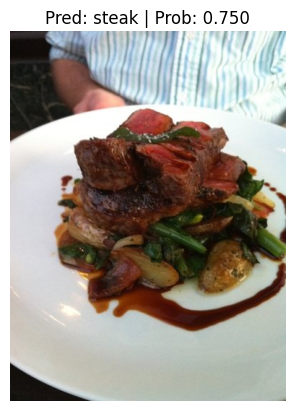

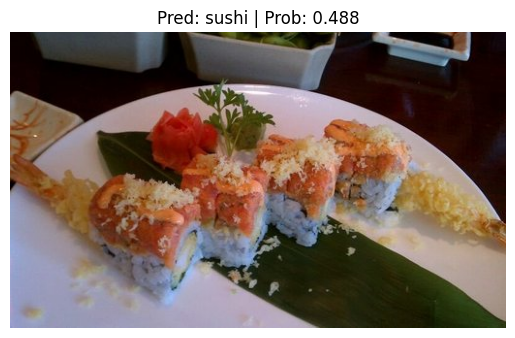

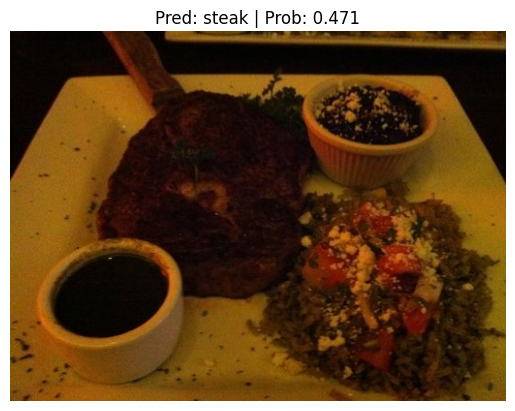

In [36]:
# Import function to make predictions on images and plot them 
# See the function previously created in section: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
from going_modular.going_modular.predictions import pred_and_plot_image

# Get a random list of 3 images from 20% test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent_path / "test").glob("*/*.jpg")) # get all test image paths from 20% dataset
test_image_path_sample = random.sample(population=test_image_path_list,
                                       k=num_images_to_plot) # randomly select k number of images

# Iterate through random test image paths, make predictions on them and plot them
for image_path in test_image_path_sample:
    pred_and_plot_image(model=best_model,
                        image_path=image_path,
                        class_names=class_names,
                        image_size=(224, 224))


Nice!

Running the cell above a few times we can see our model performs quite well and often has higher prediction probabilities than previous models we've built.

This suggests the model is more confident in the decisions it's making.

## 9.1 Predict on a custom image with the best model

Making predictions on the test dataset is cool but the real magic of machine learning is making predictions on custom images of your own.

So let's import the trusty pizza dad image (a photo of my dad in front of a pizza) we've been using for the past couple of sections and see how our model performs on it.

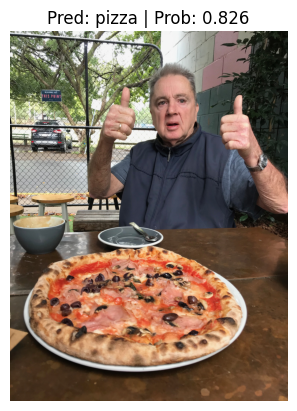

In [37]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = Path("data/04-pizza-dad.jpeg")

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

---

The main ideas you should take away from this Milestone Project 1 are:
1. 
1. The machine learning practioner's motto: experiment, experiment, experiment! (though we've been doing plenty of this already).
1. In the beginning, keep your experiments small so you can work fast, your first few experiments shouldn't take more than a few seconds to a few minutes to run.
1. The more experiments you do, the quicker you can figure out what doesn't work.
1. Scale up when you find something that works. For example, since we've found a pretty good performing model with EffNetB2 as a feature extractor, perhaps you'd now like to see what happens when you scale it up to the whole Food101 dataset from torchvision.datasets.
1. Programmatically tracking your experiments takes a few steps to set up but it's worth it in the long run so you can figure out what works and what doesn't.
1. There are many different machine learning experiment trackers out there so explore a few and try them out.

---

# EXERCISES